# Thick Sample Ptychography Reconstruction Tutorial 2D

This tutorial demonstrates how to use `thick_ptycho` to Reconstruction a problem with multiple probes via PWE and Multislice.


### 1. Import Libraries: Sample Space and Forward Model


In [1]:
import os
from thick_ptycho.reconstruction.ms_reconstructor import ReconstructorMS
from thick_ptycho.reconstruction.pwe_reconstructor import ReconstructorPWE

from thick_ptycho.simulation.config import SimulationConfig, ProbeConfig
from thick_ptycho.simulation.ptycho_probe import create_ptycho_probes
from thick_ptycho.simulation.scan_frame import Limits
from thick_ptycho.simulation.simulation_space import create_simulation_space

import time
import numpy as np

from scipy.ndimage import zoom

from utils import plot_data

## 2. Load Simulated Data

In [2]:
# File path
npz_file_path = os.path.join("./data", "padded_simulated_data_petsc_5_balls.npz")

# Load the file. MUST use allow_pickle=True since the config was pickled.
loaded_data = np.load(npz_file_path, allow_pickle=True)

# Accessing the contents:

# 1. Load the NumPy arrays directly
exit_waves = loaded_data["exit_waves"]
ref_index = loaded_data["ref_index"]

# 2. Load the sim_config.
loaded_sim_config = loaded_data["sim_config"].item()

print(f"Successfully loaded arrays and config from {npz_file_path}.")

Successfully loaded arrays and config from ./data/padded_simulated_data_petsc_5_balls.npz.


In [3]:
# Reduce Stepsize px
step_size_px = 10
points_per_wavelength = 2
empty_space_px = 0

print(f"Reduce Stepsize px: {loaded_sim_config['step_size_px']} -> {step_size_px}")
print(
    f"Points per wavelength: {loaded_sim_config['points_per_wavelength']} -> {points_per_wavelength}"
)
spatial_limits = Limits(
    x=loaded_sim_config["spatial_limits"]["x"],  # Sample width
    z=loaded_sim_config["spatial_limits"]["z"],  # Sample thickness
    units=loaded_sim_config["spatial_limits"]["units"],
)
probe_config = ProbeConfig(
    type=loaded_sim_config["probe_config"]["type"],
    wave_length=loaded_sim_config["probe_config"][
        "wave_length"
    ],  # meters (0.635 μm). Visible light
    diameter=loaded_sim_config["probe_config"]["diameter"],  # [m]
    focus=loaded_sim_config["probe_config"]["focus"],  # focal length [m]
)
sim_config = SimulationConfig(
    probe_config=probe_config,
    # Spatial discretization
    scan_points=loaded_sim_config["scan_points"],
    step_size_px=step_size_px,
    pad_factor=loaded_sim_config["pad_factor"],
    solve_reduced_domain=loaded_sim_config["solve_reduced_domain"],
    points_per_wavelength=points_per_wavelength,
    spatial_limits=spatial_limits,
    # Refractive index or Transmission Function Constant Surrounding Medium
    medium=loaded_sim_config["medium"],  # 1.0 for free space
    # Logging and results
    results_dir=loaded_sim_config["results_dir"],
    use_logging=loaded_sim_config["use_logging"],
    empty_space_px=empty_space_px,
)
simulation_space = create_simulation_space(sim_config)
simulation_space.summarize()

ptycho_probes = create_ptycho_probes(simulation_space)

2025-12-15 02:28:26,673 - INFO - === Scan Summary ===
2025-12-15 02:28:26,674 - INFO -   Sample space (x-range): 1.500e-04 m
2025-12-15 02:28:26,676 - INFO -   Sample space (z-range): 7.500e-05 m
2025-12-15 02:28:26,679 - INFO -   Sample Pixels:          1501 px
2025-12-15 02:28:26,680 - INFO -   Step size:              10 px
2025-12-15 02:28:26,681 - INFO -   Number of scan points:  60
2025-12-15 02:28:26,682 - INFO -   Steps in z:             236
2025-12-15 02:28:26,684 - INFO -   Solve reduced domain:   910 px
2025-12-15 02:28:26,685 - INFO -   Max Overlap Pixels:     901 px
2025-12-15 02:28:26,686 - INFO -   Probe diameter:         1.000e-05 m
2025-12-15 02:28:26,687 - INFO -   Probe Pixels:           100 px
2025-12-15 02:28:26,688 - INFO -   Max Overlap:            9.000e-06 m
2025-12-15 02:28:26,688 - INFO -   Percentage Overlap:     90.00%



Reduce Stepsize px: 40 -> 10
Points per wavelength: 12 -> 2


## 3. Reduce Data Dimensionality

In [4]:
# Remove Empty Space Padding from ref_index
print("Cropping empty space from ref_index and exit_waves...")

print(f"original shape:{exit_waves.shape}")
if loaded_sim_config["empty_space_px"] > empty_space_px:
    crop_px = loaded_sim_config["empty_space_px"] - empty_space_px
else:
    crop_px = loaded_sim_config["empty_space_px"]
print(f"Remove px: {crop_px} pixels on each side.")
data_ew_cropped = exit_waves[
    :,
    crop_px:-crop_px,
]
print(f"cropped shape:{data_ew_cropped.shape}")

Cropping empty space from ref_index and exit_waves...
original shape:(60, 7640)
Remove px: 2000 pixels on each side.
cropped shape:(60, 3640)


Original exit waves shape: (60, 3640)
Coarse exit waves shape: (60, 910)


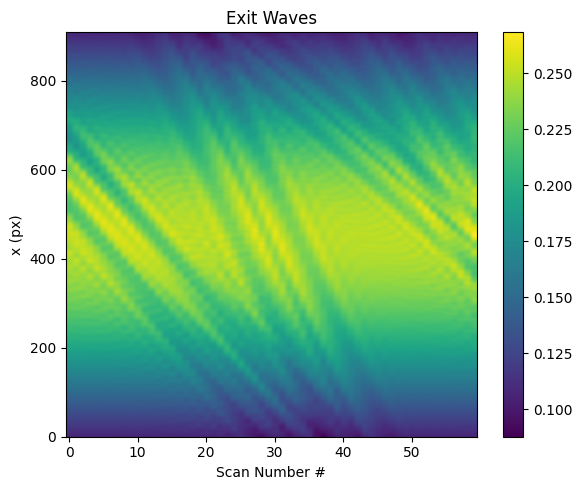

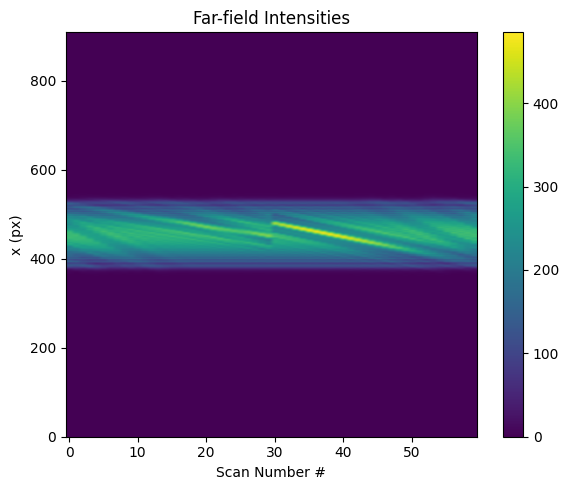

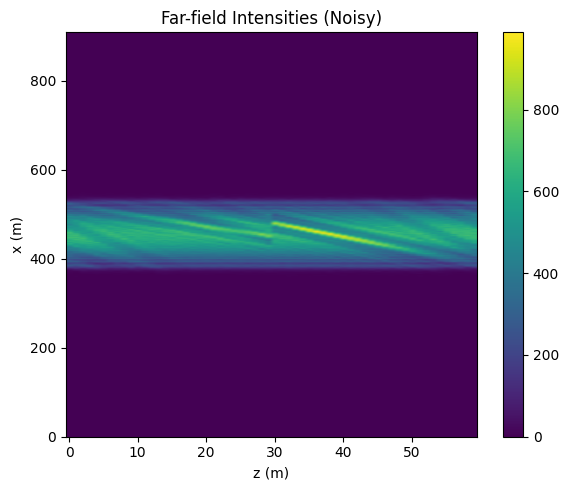

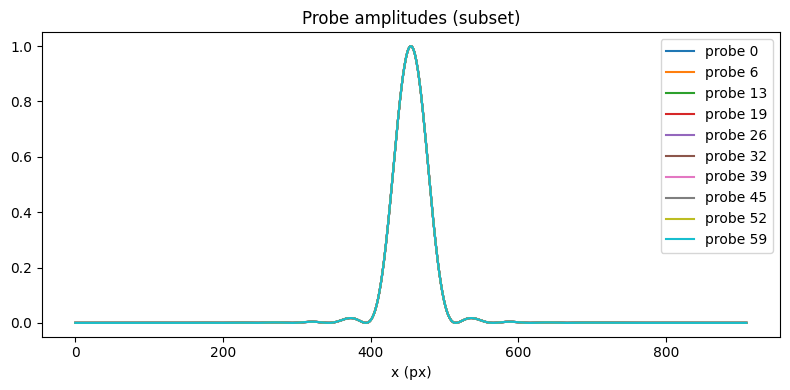

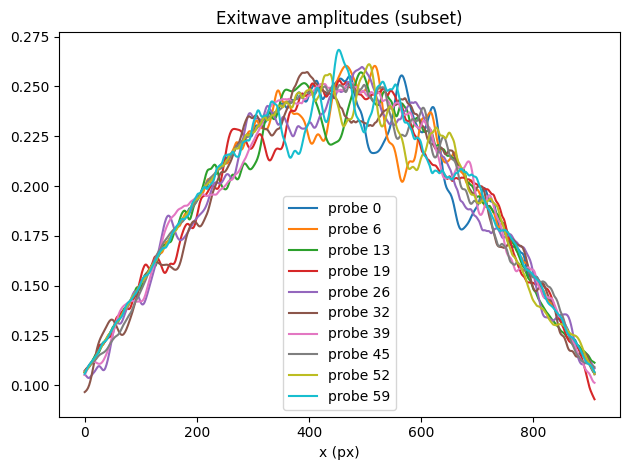

In [5]:
# Reduce Pixel Size by Zooming Exit Waves
original_shape = data_ew_cropped.shape
target_shape = (original_shape[0], simulation_space.effective_nx)
zoom_factors = np.array(target_shape) / np.array(original_shape)

data_ew = zoom(data_ew_cropped, zoom_factors, order=1)
data = np.abs(np.fft.fft(data_ew)) ** 2

print(f"Original exit waves shape: {data_ew_cropped.shape}")
print(f"Coarse exit waves shape: {data_ew.shape}")

plot_data(
    data=data,
    exitwaves=data_ew,
    simulation_space=simulation_space,
    probes=ptycho_probes,
)

Original ref_index shape: (6001, 1417)


(<Figure size 1000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Original Refractive Index Phase'}, xlabel='z (px)', ylabel='x (px)'>,
        <Axes: title={'center': 'Original Refractive Index Amplitude'}, xlabel='z (px)', ylabel='x (px)'>],
       dtype=object))

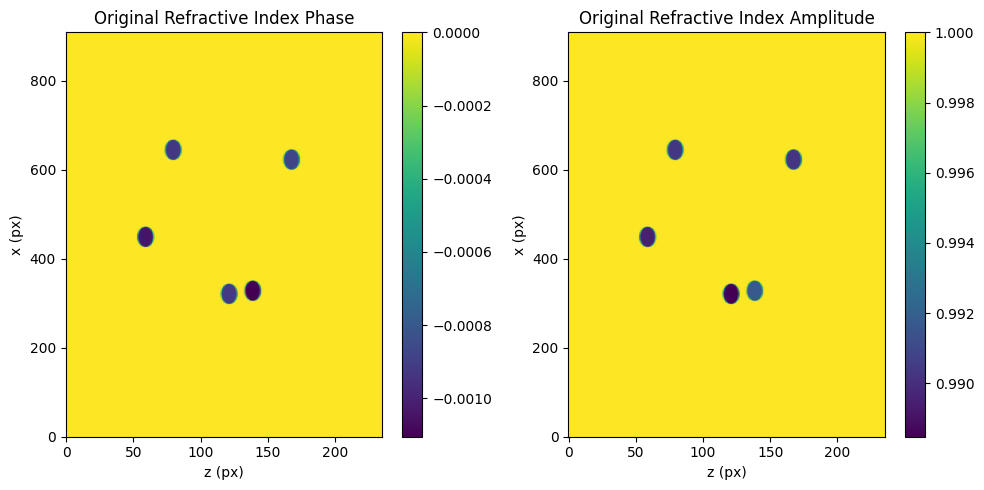

In [6]:
# Original Refactive Index Shap
ref_index_shape = ref_index.shape
print(f"Original ref_index shape: {ref_index_shape}")
target_shape = (simulation_space.effective_nx, simulation_space.nz)
zoom_factors = np.array(target_shape) / np.array(ref_index_shape)
ref_index_zoomed = zoom(ref_index, zoom_factors)
simulation_space.viewer.plot_two_panels(
    ref_index_zoomed,  # Use ifftshift to move zero frequency to the corner
    title="Original Refractive Index",
    xlabel="z (px)",
    ylabel="x (px)",
)

### 4. Reconstructs on Coarser nz Discretization
The exit wave of the forward solution can be set as the initial condition for
the system to be solved in reverse. 

2025-12-15 02:28:29,261 - INFO - Initialized Multislice 3PIE Reconstructor.
2025-12-15 02:28:31,263 - INFO - [Iter 001] Mean Loss = 0.039433, Time = 1.99 seconds
2025-12-15 02:28:33,393 - INFO - [Iter 002] Mean Loss = 0.038412, Time = 2.13 seconds
2025-12-15 02:28:36,193 - INFO - [Iter 003] Mean Loss = 0.038060, Time = 2.80 seconds
2025-12-15 02:28:40,632 - INFO - [Iter 004] Mean Loss = 0.037889, Time = 4.43 seconds
2025-12-15 02:28:43,918 - INFO - [Iter 005] Mean Loss = 0.037794, Time = 3.28 seconds
2025-12-15 02:28:48,716 - INFO - [Iter 006] Mean Loss = 0.037738, Time = 4.79 seconds
2025-12-15 02:28:50,629 - INFO - [Iter 007] Mean Loss = 0.037703, Time = 1.91 seconds
2025-12-15 02:28:52,946 - INFO - [Iter 008] Mean Loss = 0.037681, Time = 2.31 seconds
2025-12-15 02:28:55,068 - INFO - [Iter 009] Mean Loss = 0.037668, Time = 2.12 seconds
2025-12-15 02:28:56,950 - INFO - [Iter 010] Mean Loss = 0.037660, Time = 1.88 seconds


Reconstruction time: 27.69 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residuals for MS Reconstruction'}, xlabel='Iteration', ylabel='RMSE'>)

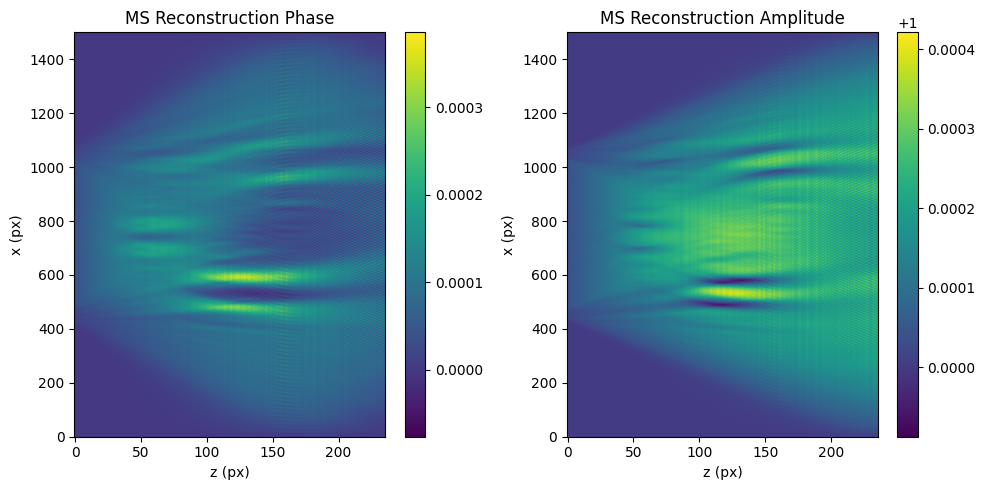

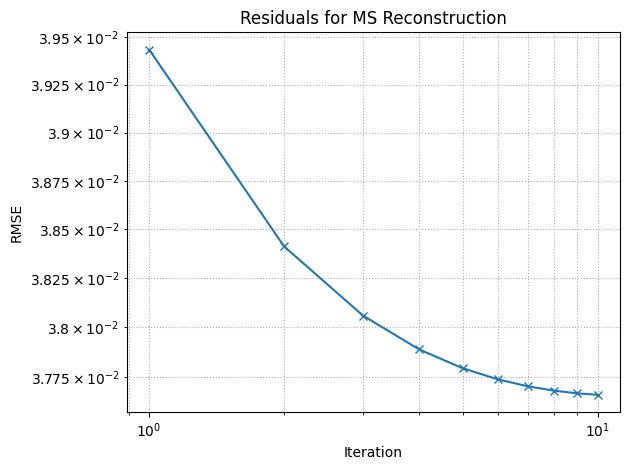

In [ ]:
recon_ms = ReconstructorMS(simulation_space, data, phase_retrieval=True, verbose=True)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=10, alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")

simulation_space.viewer.plot_two_panels(
    n_est_ms,
    view="phase_amp",
    title="MS Reconstruction",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_ms,
    title="Residuals for MS Reconstruction",
)

/home/dnz75396/thick_ptycho/thick_ptycho/forward_model/pwe/solvers/utils/_pint_utils.py:171: SparseEfficiencyWarning: splu converted its input to CSC format
  spla.splu((self.A_bar - (z * self.B_bar)).astype(self.dtype))
/home/dnz75396/thick_ptycho/thick_ptycho/forward_model/pwe/solvers/utils/_pint_utils.py:184: SparseEfficiencyWarning: splu converted its input to CSC format
  spla.splu((A_bar_H - (z_conj * B_bar_H)).astype(self.dtype))
2025-12-15 02:28:58,144 - INFO - Initializing Least Squares Solver...
2025-12-15 02:28:58,167 - INFO - Iteration 1/10
2025-12-15 02:29:03,838 - INFO -     RMSE: 0.030582572949882942
2025-12-15 02:29:25,500 - INFO -     Iteration 1 took 27.33 seconds.
2025-12-15 02:29:25,535 - INFO - Iteration 2/10
2025-12-15 02:29:39,764 - INFO -     RMSE: 0.028366889837504527
2025-12-15 02:30:26,761 - INFO -     Iteration 2 took 61.23 seconds.
2025-12-15 02:30:26,764 - INFO - Iteration 3/10
2025-12-15 02:30:47,159 - INFO -     RMSE: 0.027660677952696597
2025-12-15 02:3

Reconstruction time: 642.12 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residuals for PWE Reconstruction'}, xlabel='Iteration', ylabel='RMSE'>)

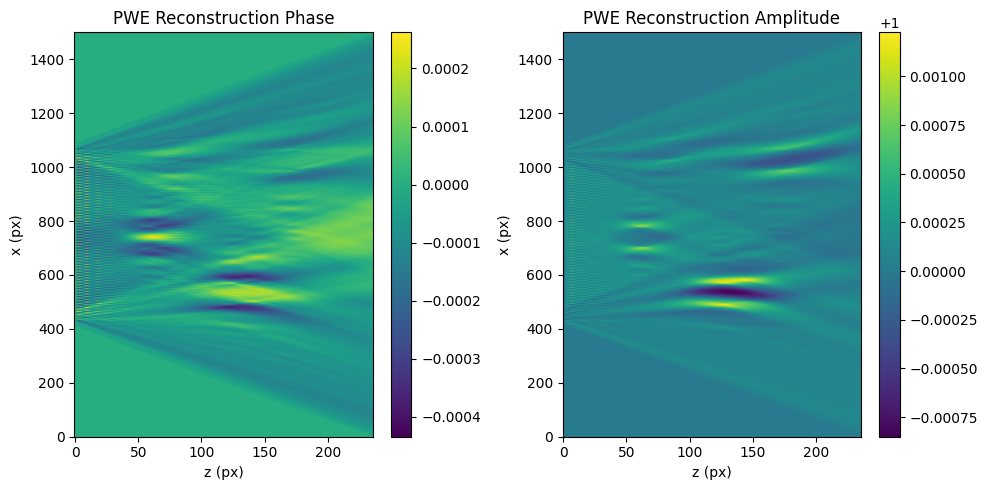

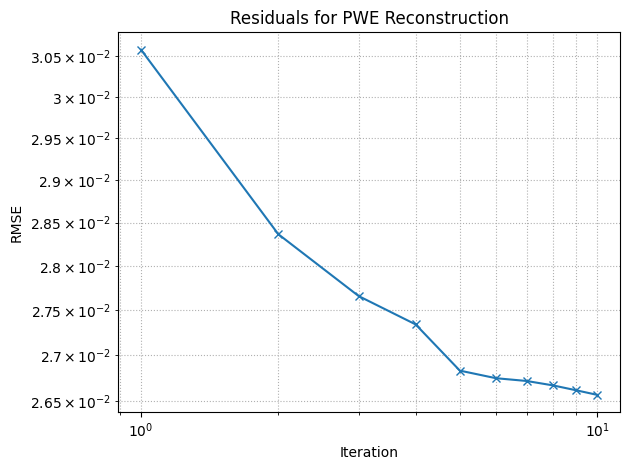

In [8]:
atol = 1e-4
alpha = 1e-8
recon_pwe = ReconstructorPWE(
    simulation_space,
    data,
    phase_retrieval=True,
    verbose=True,
    solver_type="full",
    alpha=alpha,
    atol=atol,
)
time_start = time.time()
n_est_pwe, u, residual_pwe = recon_pwe.reconstruct(max_iters=10)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")

simulation_space.viewer.plot_two_panels(
    n_est_pwe,
    view="phase_amp",
    title="PWE Reconstruction",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_pwe,
    title="Residuals for PWE Reconstruction",
)

2025-12-15 02:41:48,591 - INFO - Initializing Least Squares Solver...
2025-12-15 02:41:48,621 - INFO - Iteration 1/10
2025-12-15 02:41:54,620 - INFO -     RMSE: 0.12743118117607932
2025-12-15 02:42:07,213 - INFO -     Iteration 1 took 18.59 seconds.
2025-12-15 02:42:07,215 - INFO - Iteration 2/10
2025-12-15 02:42:24,853 - INFO -     RMSE: 0.143978112475828
2025-12-15 02:43:18,123 - INFO -     Iteration 2 took 70.91 seconds.
2025-12-15 02:43:18,123 - INFO - Iteration 3/10
2025-12-15 02:43:30,761 - INFO -     RMSE: 0.13915328463215126
2025-12-15 02:44:16,271 - INFO -     Iteration 3 took 58.15 seconds.
2025-12-15 02:44:16,272 - INFO - Iteration 4/10
2025-12-15 02:44:28,267 - INFO -     RMSE: 0.11983264527211979
2025-12-15 02:45:22,607 - INFO -     Iteration 4 took 66.34 seconds.
2025-12-15 02:45:22,611 - INFO - Iteration 5/10
2025-12-15 02:45:36,299 - INFO -     RMSE: 0.12787284879749822
2025-12-15 02:46:27,889 - INFO -     Iteration 5 took 65.28 seconds.
2025-12-15 02:46:27,890 - INFO -

Reconstruction time: 1148.75 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residuals for PWE Reconstruction'}, xlabel='Iteration', ylabel='RMSE'>)

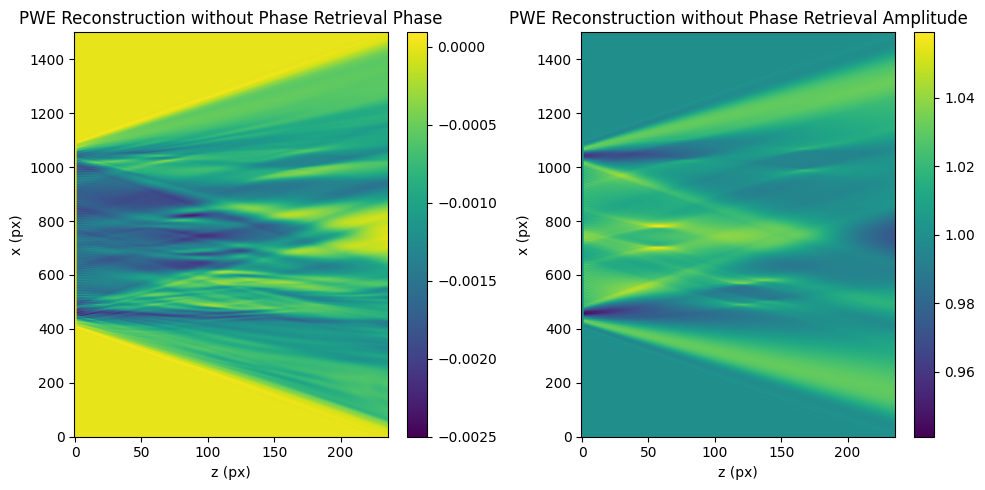

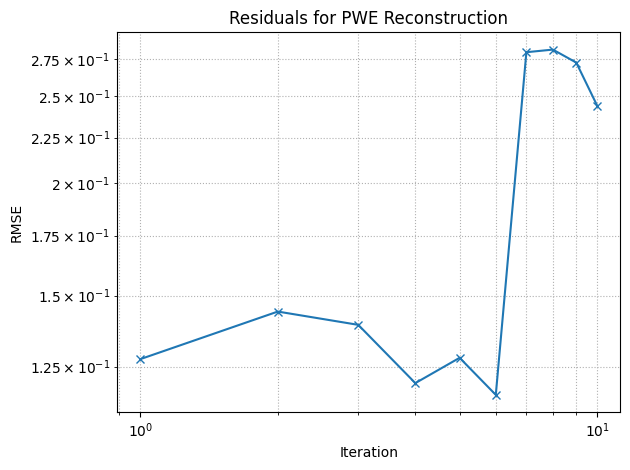

In [10]:
atol = 1e-4
alpha = 1e-8
recon_pwe = ReconstructorPWE(
    simulation_space,
    data_ew,
    phase_retrieval=False,
    verbose=True,
    solver_type="full",
    alpha=alpha,
    atol=atol,
)
time_start = time.time()
n_est_pwe, u, residual_pwe = recon_pwe.reconstruct(max_iters=10)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")

simulation_space.viewer.plot_two_panels(
    n_est_pwe,
    view="phase_amp",
    title="PWE Reconstruction without Phase Retrieval",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_pwe,
    title="Residuals for PWE Reconstruction",
)

2025-12-15 03:00:58,183 - INFO - Initialized Multislice 3PIE Reconstructor.
2025-12-15 03:00:59,935 - INFO - [Iter 001] Mean Loss = 0.169948, Time = 1.75 seconds
2025-12-15 03:01:04,548 - INFO - [Iter 002] Mean Loss = 0.158201, Time = 4.61 seconds
2025-12-15 03:01:06,199 - INFO - [Iter 003] Mean Loss = 0.154318, Time = 1.65 seconds
2025-12-15 03:01:07,840 - INFO - [Iter 004] Mean Loss = 0.152326, Time = 1.64 seconds
2025-12-15 03:01:09,483 - INFO - [Iter 005] Mean Loss = 0.151104, Time = 1.64 seconds
2025-12-15 03:01:11,135 - INFO - [Iter 006] Mean Loss = 0.150275, Time = 1.65 seconds
2025-12-15 03:01:12,805 - INFO - [Iter 007] Mean Loss = 0.149674, Time = 1.67 seconds
2025-12-15 03:01:14,429 - INFO - [Iter 008] Mean Loss = 0.149218, Time = 1.62 seconds
2025-12-15 03:01:16,057 - INFO - [Iter 009] Mean Loss = 0.148860, Time = 1.63 seconds
2025-12-15 03:01:18,060 - INFO - [Iter 010] Mean Loss = 0.148570, Time = 2.00 seconds


Reconstruction time: 19.88 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residuals for MS Reconstruction'}, xlabel='Iteration', ylabel='RMSE'>)

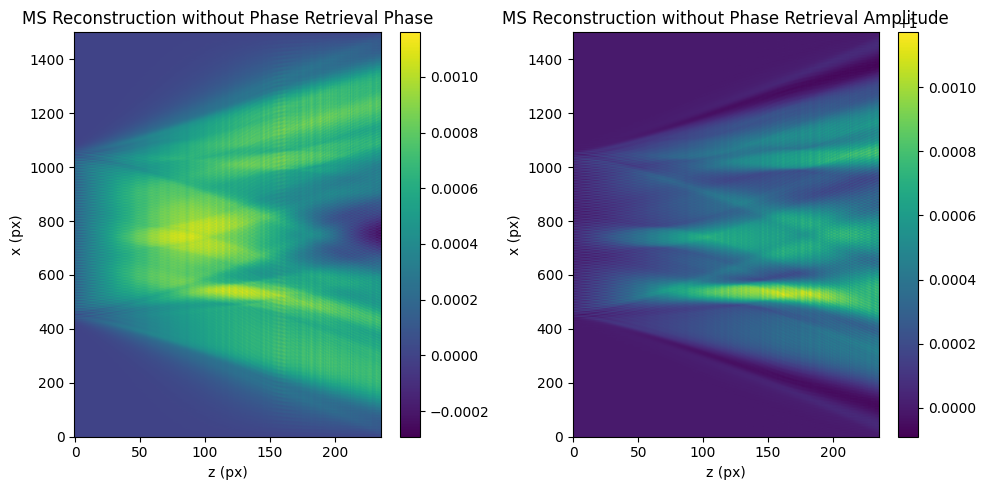

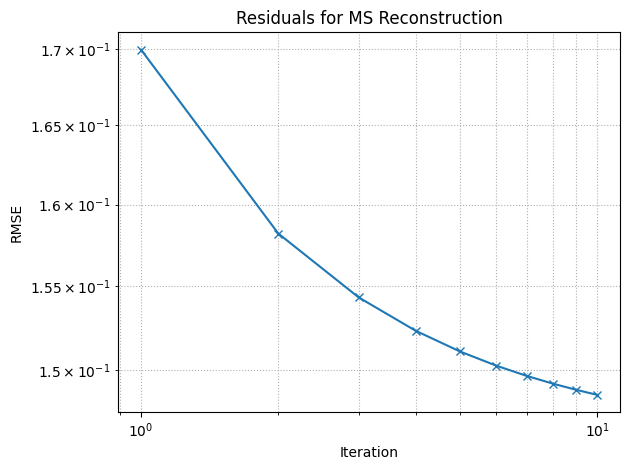

In [11]:
recon_ms = ReconstructorMS(
    simulation_space, data_ew, phase_retrieval=False, verbose=True
)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=10, alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")

simulation_space.viewer.plot_two_panels(
    n_est_ms,
    view="phase_amp",
    title="MS Reconstruction without Phase Retrieval",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_ms,
    title="Residuals for MS Reconstruction",
)